In [ ]:
#@title Connect to google drive
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title Install needed repositories
!pip install mmcv-full==v1.3.9 -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.9.0/index.html

In [ ]:
#@title Clone ViTDope
%cd /content/
! git clone https://github.com/noellelaw/vit-dope
%cd /content/vit-dope
! pip install -r requirements.txt

In [ ]:
#@title Install timm and einops
! pip install timm==0.4.9 einops

In [335]:
#@title Imports
import matplotlib.pyplot as plt
import time
import numpy as np
import cv2 as cv
import random
from enum import IntEnum
from pyrr import Quaternion

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.utils.data as data
import torchvision.models as models
from torch.distributions import MultivariateNormal as MVN
from torch.nn.utils import clip_grad_norm_
from torch.nn.functional import cross_entropy

from PIL import Image
from PIL import ImageDraw
from PIL import ImageEnhance

from math import acos
from math import sqrt
from math import pi  
import math

from models.backbones import ViT
from scripts.object_detector import ObjectDetector
from models.heads import TopdownHeatmapSimpleHead

In [347]:
#@title Training hyperparameters
YCB_OBJECT = 'cracker_box'#@param{type:'string'}
IMG_PATH = '/content/drive/MyDrive/DeepLearning/test_cracker/kitchen_0/000074.right.jpg' #@param{type:'string'}
FROM_NET = '/content/drive/MyDrive/DeepLearning/cracker_box_train/net_epoch_51.pth'#@param{type:'string'}
IMAGE_SIZE = 256#@param{type:'integer'}

In [331]:
#@title ViTDope Network
class ViTDopeNetwork(nn.Module):
  def __init__(
            self,
            pretrained=False,
            numBeliefMap=9,
            numAffinity=16
            ):
    super(ViTDopeNetwork, self).__init__()
    # Set up backbone accordance with ViT-B
    backbone = ViT(img_size=(256,256),
                  patch_size=16,
                  embed_dim=768,
                  depth=12,
                  num_heads=12,
                  ratio=1,
                  use_checkpoint=False,
                  mlp_ratio=4,
                  qkv_bias=True,
                  drop_path_rate=0.3,
    )
    # Init ViT weights from ViT MAE trained on image net
    if not PRETRAINED == '':
        backbone.init_weights(pretrained=PRETRAINED)
    # Set classical decoder head for belief maps
    belief_head = TopdownHeatmapSimpleHead(
        in_channels=768,
        num_deconv_layers=2,
        num_deconv_filters=(256, 256),
        num_deconv_kernels=(4, 4),
        extra=dict(final_conv_kernel=1, ),
        out_channels=numBeliefMap,
        loss_keypoint=dict(type='JointsMSELoss', use_target_weight=True)
    )
    # Set classical decoder head for affity maps
    affinity_head = TopdownHeatmapSimpleHead(
        in_channels=768,
        num_deconv_layers=2,
        num_deconv_filters=(256, 256),
        num_deconv_kernels=(4, 4),
        extra=dict(final_conv_kernel=1, ),
        out_channels=numAffinity,
        loss_keypoint=dict(type='JointsMSELoss', use_target_weight=True)
    )

    self.backbone = nn.Sequential(*[backbone])
    self.belief_head = nn.Sequential(*[belief_head])
    self.affinity_head = nn.Sequential(*[affinity_head])

  # Forward
  def forward(self, x):
    backbone_out = self.backbone(x)
    belief_out = self.belief_head(backbone_out)
    affinity_out = self.affinity_head(backbone_out)
    return belief_out, affinity_out




In [341]:
#@title Visualization utils
# Adapted from https://github.com/NVlabs/Deep_Object_Pose
def DrawLine(point1, point2, lineColor, lineWidth,draw):
    if not point1 is None and not point2 is None:
        cv.line(draw, point1,point2,lineColor,lineWidth)

def DrawCube(points, which_color = 0, color = None, draw = None):
    '''Draw cube with a thick solid line across the front top edge.'''
    lineWidthForDrawing = 2
    lineWidthThick = 8
    lineColor1 = (255, 215, 0)  # yellow-ish
    lineColor2 = (12, 115, 170)  # blue-ish
    lineColor3 = (45, 195, 35)  # green-ish
    if which_color == 3:
        lineColor = lineColor3
    else:
        lineColor = lineColor1

    if not color is None:
        lineColor = color        

    # draw front
    DrawLine(points[0], points[1], lineColor, lineWidthThick, draw)
    DrawLine(points[1], points[2], lineColor, lineWidthForDrawing, draw)
    DrawLine(points[3], points[2], lineColor, lineWidthForDrawing, draw)
    DrawLine(points[3], points[0], lineColor, lineWidthForDrawing, draw)
    
    # draw back
    DrawLine(points[4], points[5], lineColor, lineWidthForDrawing, draw)
    DrawLine(points[6], points[5], lineColor, lineWidthForDrawing, draw)
    DrawLine(points[6], points[7], lineColor, lineWidthForDrawing, draw)
    DrawLine(points[4], points[7], lineColor, lineWidthForDrawing, draw)
    
    # draw sides
    DrawLine(points[0], points[4], lineColor, lineWidthForDrawing, draw)
    DrawLine(points[7], points[3], lineColor, lineWidthForDrawing, draw)
    DrawLine(points[5], points[1], lineColor, lineWidthForDrawing, draw)
    DrawLine(points[2], points[6], lineColor, lineWidthForDrawing, draw)



In [332]:
#@title Cuboid class
# Taken from https://github.com/NVlabs/Deep_Object_Pose
# TODO: Move to github
# Related to the object's local coordinate system
class CuboidVertexType(IntEnum):
    FrontTopRight = 0
    FrontTopLeft = 1
    FrontBottomLeft = 2
    FrontBottomRight = 3
    RearTopRight = 4
    RearTopLeft = 5
    RearBottomLeft = 6
    RearBottomRight = 7
    Center = 8
    TotalCornerVertexCount = 8 # Corner vertexes doesn't include the center point
    TotalVertexCount = 9

# List of the vertex indexes in each line edges of the cuboid
CuboidLineIndexes = [
    # Front face
    [ CuboidVertexType.FrontTopLeft,      CuboidVertexType.FrontTopRight ],
    [ CuboidVertexType.FrontTopRight,     CuboidVertexType.FrontBottomRight ],
    [ CuboidVertexType.FrontBottomRight,  CuboidVertexType.FrontBottomLeft ],
    [ CuboidVertexType.FrontBottomLeft,   CuboidVertexType.FrontTopLeft ],
    # Back face
    [ CuboidVertexType.RearTopLeft,       CuboidVertexType.RearTopRight ],
    [ CuboidVertexType.RearTopRight,      CuboidVertexType.RearBottomRight ],
    [ CuboidVertexType.RearBottomRight,   CuboidVertexType.RearBottomLeft ],
    [ CuboidVertexType.RearBottomLeft,    CuboidVertexType.RearTopLeft ],
    # Left face
    [ CuboidVertexType.FrontBottomLeft,   CuboidVertexType.RearBottomLeft ],
    [ CuboidVertexType.FrontTopLeft,      CuboidVertexType.RearTopLeft ],
    # Right face
    [ CuboidVertexType.FrontBottomRight,  CuboidVertexType.RearBottomRight ],
    [ CuboidVertexType.FrontTopRight,     CuboidVertexType.RearTopRight ],
]


# ========================= Cuboid3d =========================
class Cuboid3d():
    '''This class contains a 3D cuboid.'''

    # Create a box with a certain size
    def __init__(self, size3d = [1.0, 1.0, 1.0], center_location = [0, 0, 0],
        coord_system = None, parent_object = None):

        # NOTE: This local coordinate system is similar
        # to the intrinsic transform matrix of a 3d object
        self.center_location = center_location
        self.coord_system = coord_system
        self.size3d = size3d
        self._vertices = [0, 0, 0] * CuboidVertexType.TotalVertexCount

        self.generate_vertexes()

    def get_vertex(self, vertex_type):
        """Returns the location of a vertex.
        Args:
            vertex_type: enum of type CuboidVertexType
        Returns:
            Numpy array(3) - Location of the vertex type in the cuboid
        """
        return self._vertices[vertex_type]

    def get_vertices(self):
        return self._vertices

    def generate_vertexes(self):
        width, height, depth = self.size3d

        # By default just use the normal OpenCV coordinate system
        if (self.coord_system is None):
            cx, cy, cz = self.center_location
            # X axis point to the right
            right = cx + width / 2.0
            left = cx - width / 2.0
            # Y axis point downward
            top = cy - height / 2.0
            bottom = cy + height / 2.0
            # Z axis point forward
            front = cz + depth / 2.0
            rear = cz - depth / 2.0

            # List of 8 vertices of the box       
            self._vertices = [
                [right, top, front],    # Front Top Right
                [left, top, front],     # Front Top Left
                [left, bottom, front],  # Front Bottom Left
                [right, bottom, front], # Front Bottom Right
                [right, top, rear],     # Rear Top Right
                [left, top, rear],      # Rear Top Left
                [left, bottom, rear],   # Rear Bottom Left
                [right, bottom, rear],  # Rear Bottom Right
                self.center_location,   # Center
            ]
        else:
            sx, sy, sz = self.size3d
            forward = np.array(self.coord_system.forward, dtype=float) * sy * 0.5
            up = np.array(self.coord_system.up, dtype=float) * sz * 0.5
            right = np.array(self.coord_system.right, dtype=float) * sx * 0.5
            center = np.array(self.center_location, dtype=float)
            self._vertices = [
                center + forward + up + right,      # Front Top Right
                center + forward + up - right,      # Front Top Left
                center + forward - up - right,      # Front Bottom Left
                center + forward - up + right,      # Front Bottom Right
                center - forward + up  + right,     # Rear Top Right
                center - forward + up - right,      # Rear Top Left
                center - forward - up - right,      # Rear Bottom Left
                center - forward - up + right,      # Rear Bottom Right
                self.center_location,               # Center
            ]

    def get_projected_cuboid2d(self, cuboid_transform, camera_intrinsic_matrix):
        """
        Projects the cuboid into the image plane using camera intrinsics.
        Args:
            cuboid_transform: the world transform of the cuboid
            camera_intrinsic_matrix: camera intrinsic matrix
        Returns:
            Cuboid2d - the projected cuboid points
        """

        world_transform_matrix = cuboid_transform
        rvec = [0, 0, 0]
        tvec = [0, 0, 0]
        dist_coeffs = np.zeros((4, 1))

        transformed_vertices = [0, 0, 0] * CuboidVertexType.TotalVertexCount
        for vertex_index in range(CuboidVertexType.TotalVertexCount):
            vertex3d = self._vertices[vertex_index]
            transformed_vertices[vertex_index] = world_transform_matrix * vertex3d

        projected_vertices = cv.projectPoints(transformed_vertices, rvec, tvec, 
                                camera_intrinsic_matrix, dist_coeffs)

        return Cuboid2d(projected_vertices)

In [336]:
#@title PnP solver class
# Taken from https://github.com/NVlabs/Deep_Object_Pose
# Takes in identified object points and retrieves 6-DoF object pose
# PnP algorithm used is based on number of valid points identified
# TODO: Move to github

class CuboidPNPSolver(object):
    """
    This class is used to find the 6-DoF pose of a cuboid given its projected vertices.
    Runs perspective-n-point (PNP) algorithm.
    """

    # Class variables
    cv2version = cv.__version__.split('.')
    cv2majorversion = int(cv2version[0])

    def __init__(self, object_name="", camera_intrinsic_matrix = None, cuboid3d = None,
            dist_coeffs = np.zeros((4, 1))):
        self.object_name = object_name
        if (not camera_intrinsic_matrix is None):
            self._camera_intrinsic_matrix = camera_intrinsic_matrix
        else:
            self._camera_intrinsic_matrix = np.array([
                [0, 0, 0],
                [0, 0, 0],
                [0, 0, 0]
            ])
        self._cuboid3d = cuboid3d

        self._dist_coeffs = dist_coeffs

    def set_camera_intrinsic_matrix(self, new_intrinsic_matrix):
        '''Sets the camera intrinsic matrix'''
        self._camera_intrinsic_matrix = new_intrinsic_matrix

    def set_dist_coeffs(self, dist_coeffs):
        '''Sets the camera intrinsic matrix'''
        self._dist_coeffs = dist_coeffs

    def solve_pnp(self, cuboid2d_points, pnp_algorithm = None):
        """
        Detects the rotation and traslation
        of a cuboid object from its vertexes'
        2D location in the image
        """

        location = None
        quaternion = None
        projected_points = cuboid2d_points

        cuboid3d_points = np.array(self._cuboid3d.get_vertices())
        obj_2d_points = []
        obj_3d_points = []

        for i in range(CuboidVertexType.TotalVertexCount):
            check_point_2d = cuboid2d_points[i]
            # Ignore invalid points
            if (check_point_2d is None):
                continue
            obj_2d_points.append(check_point_2d)
            obj_3d_points.append(cuboid3d_points[i])

        obj_2d_points = np.array(obj_2d_points, dtype=float)
        obj_3d_points = np.array(obj_3d_points, dtype=float)

        valid_point_count = len(obj_2d_points)
        print(valid_point_count, "valid points found" )

        # Set PNP algorithm based on OpenCV version and number of valid points
        is_points_valid = False

        if pnp_algorithm is None:
            if CuboidPNPSolver.cv2majorversion == 2:
                is_points_valid = True
                pnp_algorithm = cv.CV_ITERATIVE
            elif CuboidPNPSolver.cv2majorversion > 2:
                if valid_point_count >= 6:
                    is_points_valid = True
                    pnp_algorithm = cv.SOLVEPNP_ITERATIVE
                elif valid_point_count >= 4:
                    is_points_valid = True
                    pnp_algorithm = cv.SOLVEPNP_P3P
                    # This algorithm requires EXACTLY four points, so we truncate our
                    # data
                    obj_3d_points = obj_3d_points[:4]
                    obj_2d_points = obj_2d_points[:4]
                    # Alternative algorithms:
                    # pnp_algorithm = SOLVE_PNP_EPNP
            else:
                assert False, "DOPE will not work with versions of OpenCV earlier than 2.0"

        if is_points_valid:
            try:
                ret, rvec, tvec = cv2.solvePnP(
                    obj_3d_points,
                    obj_2d_points,
                    self._camera_intrinsic_matrix,
                    self._dist_coeffs,
                    flags=pnp_algorithm
                )
            except:
                # solvePnP will assert if there are insufficient points for the
                # algorithm
                print("cv2.solvePnP failed with an error")
                ret = False

            if ret:
                location = list(x[0] for x in tvec)
                quaternion = self.convert_rvec_to_quaternion(rvec)

                projected_points, _ = cv.projectPoints(cuboid3d_points, rvec, tvec, self._camera_intrinsic_matrix, self._dist_coeffs)
                projected_points = np.squeeze(projected_points)

                # If the location.Z is negative or object is behind the camera then flip both location and rotation
                x, y, z = location
                if z < 0:
                    # Get the opposite location
                    location = [-x, -y, -z]

                    # Change the rotation by 180 degree
                    rotate_angle = np.pi
                    rotate_quaternion = Quaternion.from_axis_rotation(location, rotate_angle)
                    quaternion = rotate_quaternion.cross(quaternion)

        return location, quaternion, projected_points

    def convert_rvec_to_quaternion(self, rvec):
        '''Convert rvec (which is log quaternion) to quaternion'''
        theta = np.sqrt(rvec[0] * rvec[0] + rvec[1] * rvec[1] + rvec[2] * rvec[2])  # in radians
        raxis = [rvec[0] / theta, rvec[1] / theta, rvec[2] / theta]

        # pyrr's Quaternion (order is XYZW), https://pyrr.readthedocs.io/en/latest/oo_api_quaternion.html
        return Quaternion.from_axis_rotation(raxis, theta)

        # Alternatively: pyquaternion
        # return Quaternion(axis=raxis, radians=theta)  # uses OpenCV's Quaternion (order is WXYZ)

    def project_points(self, rvec, tvec):
        '''Project points from model onto image using rotation, translation'''
        output_points, tmp = cv.projectPoints(
            self.__object_vertex_coordinates,
            rvec,
            tvec,
            self.__camera_intrinsic_matrix,
            self.__dist_coeffs)

        output_points = np.squeeze(output_points)
        return output_points

In [348]:
#@title Load model
net = ViTDopeNetwork()
net = net.to('cuda')
# Load for inference or to resume training
if FROM_NET!= '':
    net.load_state_dict(torch.load(FROM_NET))

In [349]:
#@title Run Inference
# Adapted from https://github.com/NVlabs/Deep_Object_Pose
# Global transform for image input
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
    transforms.ToTensor(),
    ])
# Camera intrisics matrix
camera_intrinsics = np.array([
    768.16058349609375, 0, 480,
    0, 768.16058349609375, 270,
    0, 0, 1
]).reshape((3,3))
# YCB object dimensions
dimensions = {
    "cracker": [16.403600692749023,21.343700408935547,7.179999828338623]
    }

# Run inference
def _run_inference(in_img, make_belief_debug_img=False, norm_belief=True, overlay_image=True):
    # Put network into evaluation mode
    net.eval()
    # Start time for inference
    start = time.time()
    # Incase no image is given
    if in_img is None:
        return []

    # Run network inference
    image_tensor = transform(in_img)
    image_torch = Variable(image_tensor).cuda().unsqueeze(0)
    output_belief, output_affinities = net(image_torch) 
    # Find detected objects from network output
    vertex = output_belief[-1]
    aff = output_affinities[-1]
    detected_objects = ObjectDetector.find_object_poses(vertex, aff)
    # Set up cuboid to pass into pnp solver in accordance with object dimmensions
    cuboid = Cuboid3d(size3d=dimensions['cracker'])
    # Set up pnp solver
    pnp_solver = CuboidPNPSolver('cracker_box', camera_intrinsics, cuboid)
    # For each object identified, find the 6-DoF pose using PnP
    for i, obj in enumerate(detected_objects):
      points = obj['cuboid2d']
      # Run PNP
      location, quaternion, projected_points = pnp_solver.solve_pnp(points)
      # Add results to detected object
      detected_objects[i]['location'] = location
      detected_objects[i]['quaternion'] = quaternion
      detected_objects[i]['projected_points'] = projected_points
    # Time inference ends
    end = time.time()
    print(f'Inference time: {end-start}s')
    # Return values of interest
    return detected_objects, vertex, image_tensor

# Call _run_inference
in_image = Image.open(IMG_PATH)
data, maps, imgs = _run_inference(in_image,make_belief_debug_img=True)

Objects detected:  [{'name': 'cracker_box', 'cuboid2d': array([[500.05557891, 275.74793992],
       [499.47026088, 315.52667842],
       [315.41768204, 291.8508752 ],
       [499.94408376, 323.68809873],
       [499.72824917, 315.48207603],
       [499.45262507, 331.75947308],
       [500.55481876, 332.07748121],
       [363.51396793, 219.40520036],
       [419.44564194, 275.63815635]]), 'score': 0.24135461}]
9 valid points found
Inference time: 0.06067609786987305s


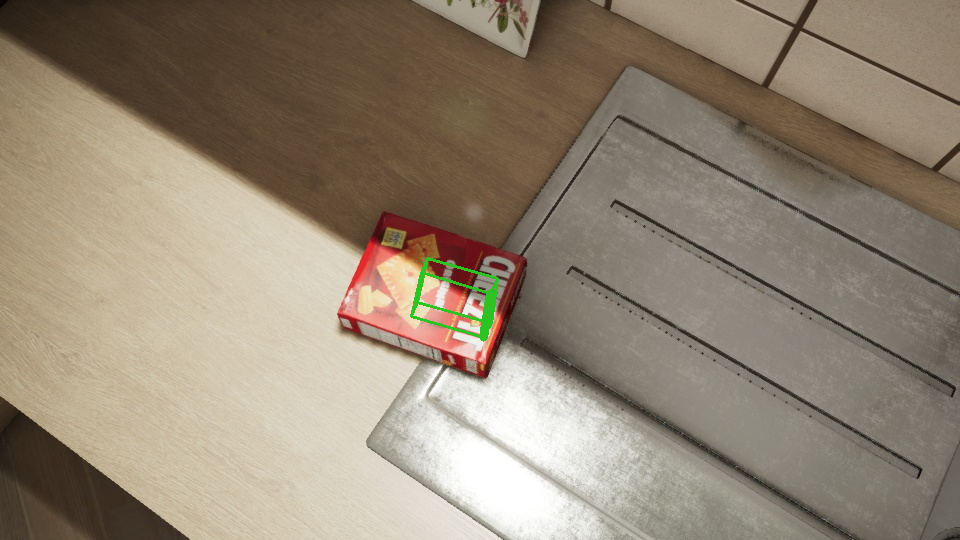

In [352]:
#@title Visualize projected points on image
color = None
# Read in input image
in_image = cv.imread(IMG_PATH)
in_image = cv.cvtColor(in_image, cv.COLOR_BGR2RGB)
for obj in data:
      points = obj['projected_points'][:8].astype('uint32')
      # Draw all the found objects.
      DrawCube(points, which_color=3, draw=in_image)
# Display the image
Image.fromarray(in_image)